In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = None
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize

from splinedist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from splinedist.matching import matching, matching_dataset
from splinedist.models import Config2D, SplineDist2D, SplineDistData2D

np.random.seed(42)
lbl_cmap = random_label_cmap()

import splinegenerator as sg
from splinedist.utils import phi_generator, grid_generator, get_contoursize_max
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
from skimage.transform import resize

# Data

We assume that data has already been downloaded via notebook [1_data.ipynb](1_data.ipynb).  

<div class="alert alert-block alert-info">
Training data (for input `X` with associated label masks `Y`) can be provided via lists of numpy arrays, where each image can have a different size. Alternatively, a single numpy array can also be used if all images have the same size. Label images need to be integer-valued.
</div>

In [2]:
X = sorted(glob("/home/georgeos/Storage/Dropbox (Cambridge University)/PhD_Georgeos_Hardo/ML_based_segmentation_results/40x_Ph2_test_1.5/PC_training_data/bent_noisematched_allsize_emptytrench/convolutions/*.tif"))
Y = sorted(glob("/home/georgeos/Storage/Dropbox (Cambridge University)/PhD_Georgeos_Hardo/ML_based_segmentation_results/40x_Ph2_test_1.5/PC_training_data/bent_noisematched_allsize_emptytrench/masks/*.tif"))
assert all(Path(x).name==Path(y).name for x,y in zip(X,Y))

In [3]:
X = list(map(imread,X))
Y = list(map(imread,Y))
n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]

In [4]:
requires_resize = True
resize_shape = (256,64)
if requires_resize:
    Y = [resize(y,resize_shape, order=0, mode='reflect', cval=0, clip=True, preserve_range=True, anti_aliasing=None, anti_aliasing_sigma=None).astype(int) for y in tqdm(Y)]
    X = [resize(x,resize_shape, order=0, mode='reflect', cval=0, clip=True, preserve_range=True, anti_aliasing=None, anti_aliasing_sigma=None) for x in tqdm(X)]

100%|██████████| 7747/7747 [00:04<00:00, 1861.01it/s]


Normalize images and fill small label holes.

In [5]:
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
    sys.stdout.flush()

X = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X)]
Y = [fill_label_holes(y) for y in tqdm(Y)]

100%|██████████| 7747/7747 [00:04<00:00, 1788.50it/s]


Split into train and validation datasets.

In [6]:
assert len(X) > 1, "not enough training data"
rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
n_val = max(1, int(round(0.3 * len(ind))))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]
X_val, Y_val = [X[i] for i in ind_val]  , [Y[i] for i in ind_val]
X_trn, Y_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train] 
print('number of images: %3d' % len(X))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))

number of images: 7747
- training:       5423
- validation:     2324


Training data consists of pairs of input image and label instances.

In [7]:
def plot_img_label(img, lbl, img_title="image", lbl_title="label", **kwargs):
    fig, (ai,al) = plt.subplots(1,2, figsize=(12,5), gridspec_kw=dict(width_ratios=(1.25,1)))
    im = ai.imshow(img, cmap='gray', clim=(0,1))
    ai.set_title(img_title)    
    fig.colorbar(im, ax=ai)
    al.imshow(lbl, cmap=lbl_cmap)
    al.set_title(lbl_title)
    plt.tight_layout()

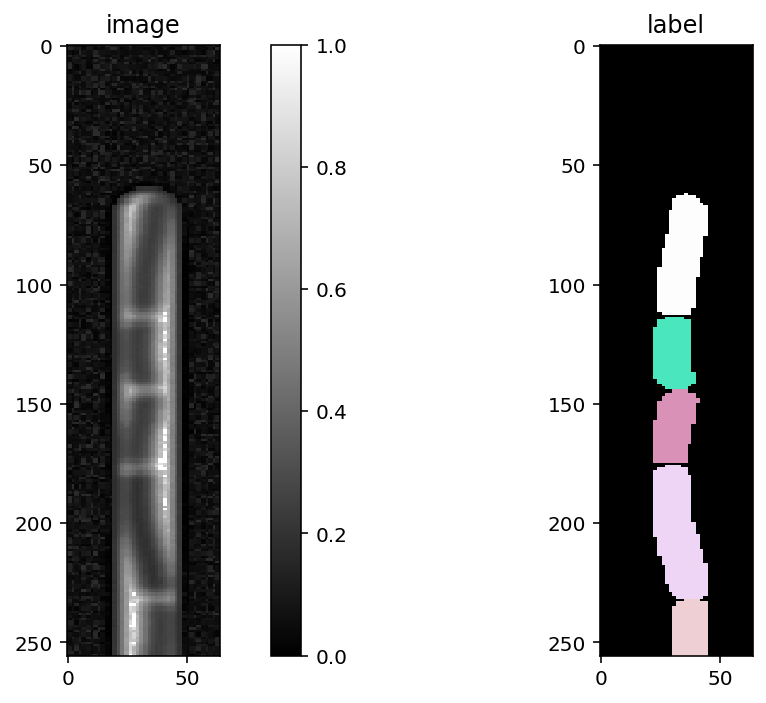

In [8]:
i = min(9, len(X)-1)
img, lbl = X[i], Y[i]
assert img.ndim in (2,3)
img = img if (img.ndim==2 or img.shape[-1]==3) else img[...,0]
plot_img_label(img,lbl)
None;

# Configuration

A `SplineDist2D` model is specified via a `Config2D` object.

In [9]:
print(Config2D.__doc__)

Configuration for a :class:`SplineDist2D` model.

    Parameters
    ----------
    axes : str or None
        Axes of the input images.
    n_params : int
        2 * number of control points
    n_channel_in : int
        Number of channels of given input image (default: 1).
    grid : (int,int)
        Subsampling factors (must be powers of 2) for each of the axes.
        Model will predict on a subsampled grid for increased efficiency and larger field of view.
    backbone : str
        Name of the neural network architecture to be used as backbone.
    contoursize_max : int
        A number greater than the size of the largest contour present in the image-set.
    kwargs : dict
        Overwrite (or add) configuration attributes (see below).


    Attributes
    ----------
    unet_n_depth : int
        Number of U-Net resolution levels (down/up-sampling layers).
    unet_kernel_size : (int,int)
        Convolution kernel size for all (U-Net) convolution layers.
    unet_n_filter

In [10]:
# choose the number of control points (M)
M = 8
n_params = 2 * M

# Predict on subsampled grid for increased efficiency and larger field of view
grid = (2,2)

# compute the size of the largest contour present in the image-set
contoursize_max = get_contoursize_max(Y_trn)

conf = Config2D (
    n_params        = n_params,
    grid            = grid,
    n_channel_in    = n_channel,
    contoursize_max = contoursize_max,
    train_patch_size=resize_shape,
    use_gpu=True,
    unet_n_depth = 4,
    unet_n_conv_per_depth = 2,
    unet_batch_norm = True,
    unet_dropout=0.5,
    unet_last_activation="relu",
    train_learning_rate = 0.0001
)
print(conf)
vars(conf)

Config2D(n_dim=2, axes='YXC', n_channel_in=1, n_channel_out=17, train_checkpoint='weights_best.h5', train_checkpoint_last='weights_last.h5', train_checkpoint_epoch='weights_now.h5', n_params=16, grid=(2, 2), backbone='unet', contoursize_max=159, unet_n_depth=4, unet_kernel_size=(3, 3), unet_n_filter_base=32, unet_n_conv_per_depth=2, unet_pool=(2, 2), unet_activation='relu', unet_last_activation='relu', unet_batch_norm=True, unet_dropout=0.5, unet_prefix='', net_conv_after_unet=128, net_input_shape=(None, None, 1), net_mask_shape=(None, None, 1), train_shape_completion=False, train_completion_crop=32, train_patch_size=(256, 64), train_background_reg=0.0001, train_foreground_only=0.9, train_dist_loss='mae', train_loss_weights=(1, 0.2), train_epochs=400, train_steps_per_epoch=100, train_learning_rate=0.0001, train_batch_size=4, train_n_val_patches=None, train_tensorboard=True, train_reduce_lr={'factor': 0.5, 'patience': 40, 'min_delta': 0}, use_gpu=True)


{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 17,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'n_params': 16,
 'grid': (2, 2),
 'backbone': 'unet',
 'contoursize_max': 159,
 'unet_n_depth': 4,
 'unet_kernel_size': (3, 3),
 'unet_n_filter_base': 32,
 'unet_n_conv_per_depth': 2,
 'unet_pool': (2, 2),
 'unet_activation': 'relu',
 'unet_last_activation': 'relu',
 'unet_batch_norm': True,
 'unet_dropout': 0.5,
 'unet_prefix': '',
 'net_conv_after_unet': 128,
 'net_input_shape': (None, None, 1),
 'net_mask_shape': (None, None, 1),
 'train_shape_completion': False,
 'train_completion_crop': 32,
 'train_patch_size': (256, 64),
 'train_background_reg': 0.0001,
 'train_foreground_only': 0.9,
 'train_dist_loss': 'mae',
 'train_loss_weights': (1, 0.2),
 'train_epochs': 400,
 'train_steps_per_epoch': 100,
 'train_learning_rate': 0.0001,
 'train_batch_size': 4,
 'train_n_val_patches': None,
 '

In [11]:
phi_generator(M, conf.contoursize_max)
grid_generator(M, conf.train_patch_size, conf.grid)

In [16]:
model = SplineDist2D(conf, name='splinedist', basedir='/home/georgeos/Storage/Google Drive (Cambridge Univeristy)/SYMPTOMM_models/splinedisttest')

Using default values: prob_thresh=0.5, nms_thresh=0.4.


Check if the neural network has a large enough field of view to see up to the boundary of most objects.

In [17]:
median_size = calculate_extents(list(Y), np.median)
fov = np.array(model._axes_tile_overlap('YX'))
print(f"median object size:      {median_size}")
print(f"network field of view :  {fov}")
if any(median_size > fov):
    print("WARNING: median object size larger than field of view of the neural network.")

median object size:      [38.  19.5]
network field of view :  [128 128]


# Data Augmentation

You can define a function/callable that applies augmentation to each batch of the data generator.  
We here use an `augmenter` that applies random rotations, flips, and intensity changes, which are typically sensible for (2D) microscopy images (but you can disable augmentation by setting `augmenter = None`).

In [18]:
def random_fliprot(img, mask): 
    assert img.ndim >= mask.ndim
    axes = tuple(range(mask.ndim))
    perm = tuple(np.random.permutation(axes))
    img = img.transpose(perm + tuple(range(mask.ndim, img.ndim))) 
    mask = mask.transpose(perm) 
    for ax in axes: 
        if np.random.rand() > 0.5:
            img = np.flip(img, axis=ax)
            mask = np.flip(mask, axis=ax)
    return img, mask 

def random_intensity_change(img):
    img = img*np.random.uniform(0.6,2) + np.random.uniform(-0.2,0.2)
    return img


def augmenter(x, y):
    """Augmentation of a single input/label image pair.
    x is an input image
    y is the corresponding ground-truth label image
    """
    x, y = random_fliprot(x, y)
    x = random_intensity_change(x)
    # add some gaussian noise
    sig = 0.02*np.random.uniform(0,1)
    x = x + sig*np.random.normal(0,1,x.shape)
    return x, y

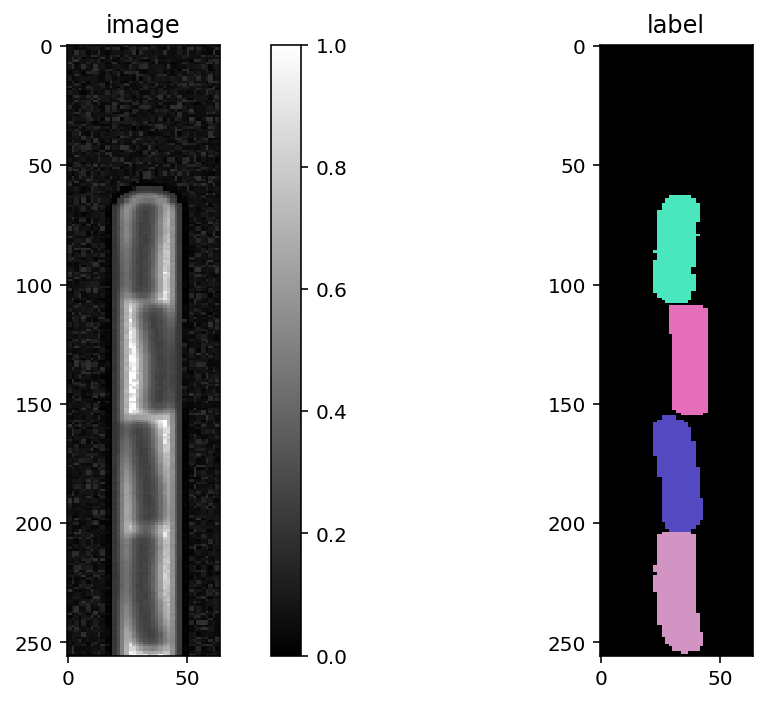

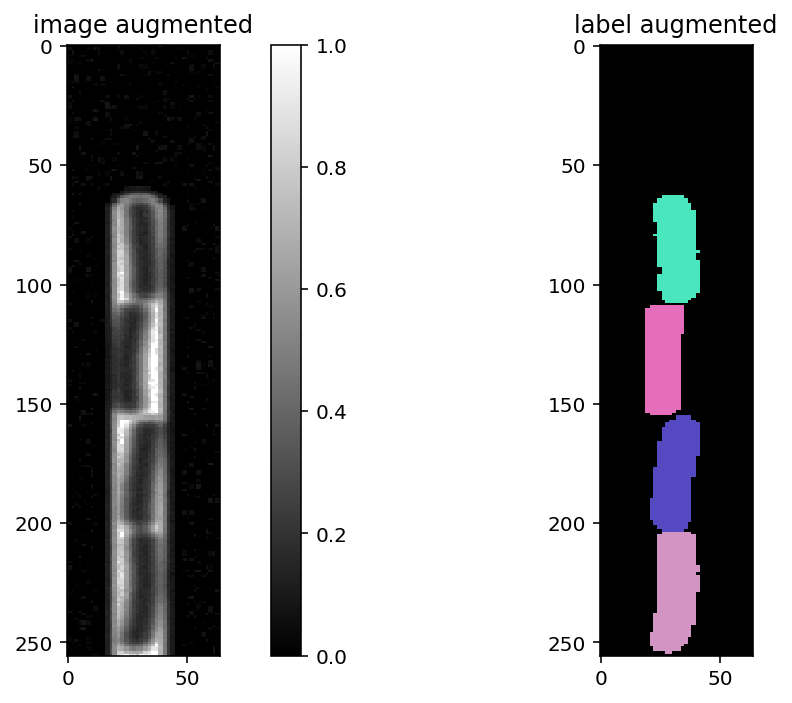

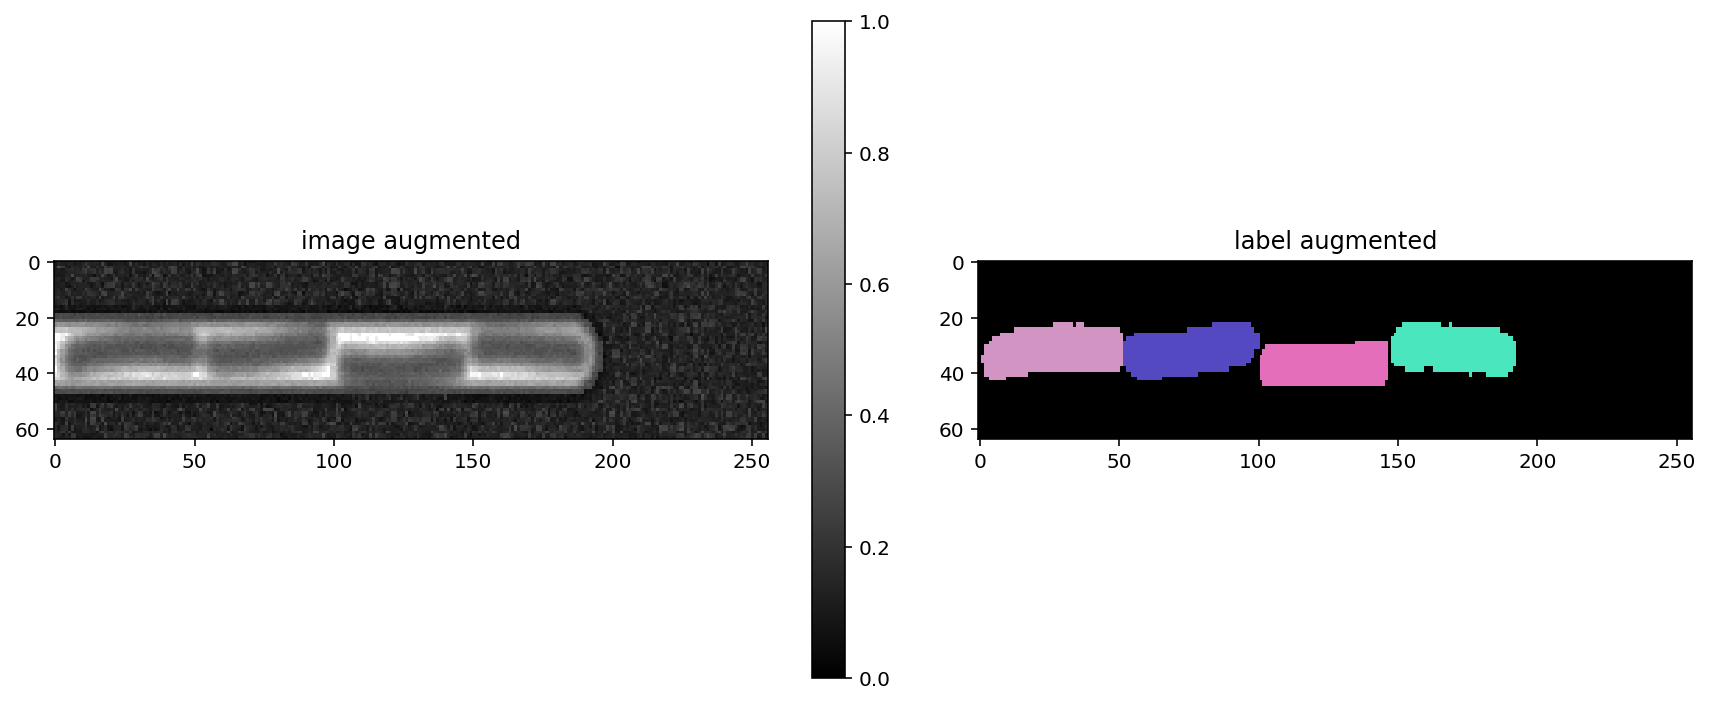

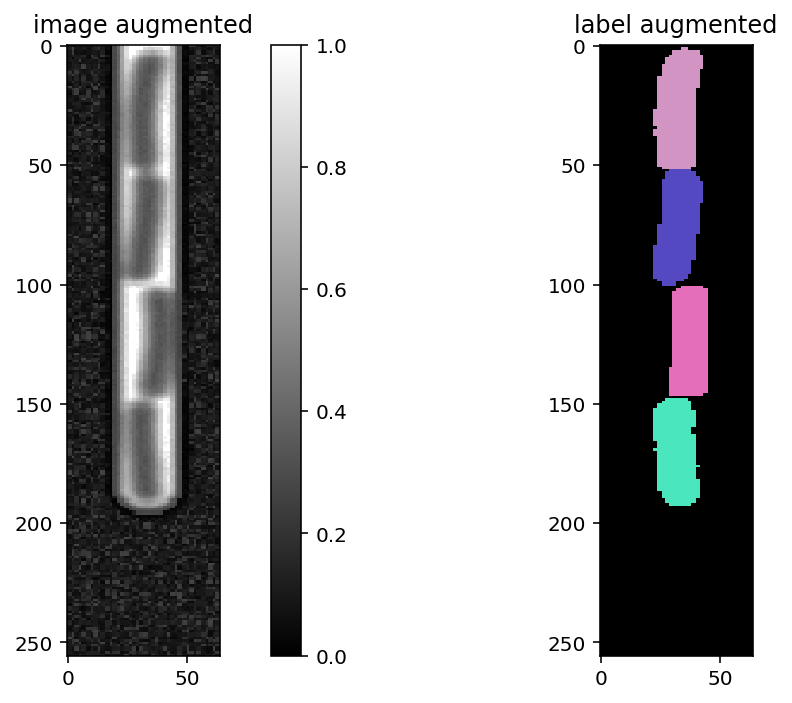

In [19]:
# plot some augmented examples
img, lbl = X[0],Y[0]
plot_img_label(img, lbl)
for _ in range(3):
    img_aug, lbl_aug = augmenter(img,lbl)
    plot_img_label(img_aug, lbl_aug, img_title="image augmented", lbl_title="label augmented")

# Training

In [ ]:
model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=augmenter, epochs = 100)

Error: Could not find scikit-tensor which is needed separable approximations...
pip install scikit-tensor-py3


In [31]:
!python

^C


In [ ]:
unet_n_depths = [5,6,7,8]
unet_activations = ["relu"]
unet_last_activations = ["sigmoid"]
for unet_n_depth in unet_n_depths:
    for unet_activation in unet_activations:
        for unet_last_activation in unet_last_activations:
            
            M = 8
            n_params = 2 * M

            # Predict on subsampled grid for increased efficiency and larger field of view
            grid = (2,2)

            # compute the size of the largest contour present in the image-set
            contoursize_max = get_contoursize_max(Y_trn)
            
            conf = Config2D(
                n_params        = n_params,
                grid            = grid,
                n_channel_in    = n_channel,
                contoursize_max = contoursize_max,
                use_gpu=True,
                train_background_reg = 0.000001,
                train_learning_rate=0.0002,
                unet_batch_norm = True,
                unet_dropout=0.3,
                train_epochs=100,
                unet_n_depth=unet_n_depth,
                unet_activation = unet_activation,
                unet_last_activation = unet_last_activation
            )
            #print(conf)
            #vars(conf)
            phi_generator(M, conf.contoursize_max)
            grid_generator(M, conf.train_patch_size, conf.grid)
            
            model = StarDist2D(conf, name='splinedist', basedir='C:\\Users\\gh464\\Document\s\GitHub\\SYMPTOMM_models\\spline_bent_noisematched_allsize_empty_und{}_una{}_unla{}'.format(unet_n_depth,unet_activation,unet_last_activation))

            model.train(X_trn,Y_trn,validation_data=(X_val,Y_val))

# Visualization

First predict the labels for all validation images:

In [ ]:
Y_val_pred = [model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)[0]
              for x in tqdm(X_val)]

Plot a GT/prediction example 

In [ ]:
plot_img_label(X_val[0],Y_val[0], lbl_title="label GT")
plot_img_label(X_val[0],Y_val_pred[0], lbl_title="label Pred")